In [ ]:
!pip install pandas numpy matplotlib seaborn datasets pyarrow scikit-learn xgboost catboost lightgbm --upgrade

In [1]:
import os
from datasets import load_dataset

# Check if dataset already exists
dataset_path = "datasets/diabetes-readmission"

if os.path.exists(dataset_path):
    print(f"Dataset already exists at {dataset_path}")
else:
    print("Downloading diabetes readmission dataset...")
    # Download the diabetes readmission dataset
    dataset = load_dataset("imodels/diabetes-readmission")

    # Save to datasets folder
    dataset.save_to_disk(dataset_path)
    print(f"Dataset downloaded and saved to {dataset_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/49.2M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/81410 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20353 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/81410 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20353 [00:00<?, ? examples/s]

Dataset downloaded and saved to datasets/diabetes-readmission


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import pyarrow as pa
import pyarrow.parquet as pq

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

In [3]:
# Load train and test datasets
train_dataset = Dataset.from_file('datasets/diabetes-readmission/train/data-00000-of-00001.arrow')
test_dataset = Dataset.from_file('datasets/diabetes-readmission/test/data-00000-of-00001.arrow')

# Convert to pandas DataFrames
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


Training set shape: (81410, 151)
Test set shape: (20353, 151)


In [4]:
# Display basic information about the dataset
print("Training Data Info:")
print(train_df.info())
print("\nFirst few rows:")
train_df.head()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81410 entries, 0 to 81409
Columns: 151 entries, time_in_hospital to readmitted
dtypes: float64(150), int64(1)
memory usage: 93.8 MB
None

First few rows:


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,gender:Female,gender:Male,age:70+,age:[0-10),age:[10-20),age:[20-50),age:[50-70),admission_type_id:Elective,admission_type_id:Emergency,admission_type_id:New Born,admission_type_id:Trauma Center,discharge_disposition_id:Discharged to Home,discharge_disposition_id:Other,admission_source_id:Emergency,admission_source_id:Other,admission_source_id:Referral,admission_source_id:Transfer,medical_specialty:Cardiology,medical_specialty:Emergency/Trauma,medical_specialty:Family/GeneralPractice,medical_specialty:Gastroenterology,medical_specialty:Hematology/Oncology,medical_specialty:InternalMedicine,medical_specialty:Nephrology,medical_specialty:ObstetricsandGynecology,medical_specialty:Orthopedics,medical_specialty:Other,medical_specialty:Psychiatry,medical_specialty:Pulmonology,medical_specialty:Radiology,medical_specialty:Surgery-Cardiovascular/Thoracic,medical_specialty:Surgery-General,medical_specialty:Urology,diag_1:Circulatory,diag_1:Diabetes,diag_1:Digestive,diag_1:Genitourinary,diag_1:Infectious,diag_1:Injury,diag_1:Mental,diag_1:Musculoskeletal,diag_1:Neoplasms,diag_1:Non-diabetes endocrine/metabolic,diag_1:Other,diag_1:Respiratory,diag_1:Skin,diag_2:Circulatory,diag_2:Diabetes,diag_2:Digestive,diag_2:Genitourinary,diag_2:Infectious,diag_2:Injury,diag_2:Mental,diag_2:Musculoskeletal,diag_2:Neoplasms,diag_2:Non-diabetes endocrine/metabolic,diag_2:Other,diag_2:Respiratory,diag_2:Skin,diag_3:Circulatory,diag_3:Diabetes,diag_3:Digestive,diag_3:Genitourinary,diag_3:Infectious,diag_3:Injury,diag_3:Mental,diag_3:Musculoskeletal,diag_3:Neoplasms,diag_3:Non-diabetes endocrine/metabolic,diag_3:Other,diag_3:Respiratory,diag_3:Skin,metformin:Down,metformin:No,metformin:Steady,metformin:Up,repaglinide:Down,repaglinide:No,repaglinide:Steady,repaglinide:Up,nateglinide:Down,nateglinide:No,nateglinide:Steady,nateglinide:Up,chlorpropamide:Down,chlorpropamide:No,chlorpropamide:Steady,chlorpropamide:Up,glimepiride:Down,glimepiride:No,glimepiride:Steady,glimepiride:Up,glipizide:Down,glipizide:No,glipizide:Steady,glipizide:Up,glyburide:Down,glyburide:No,glyburide:Steady,glyburide:Up,pioglitazone:Down,pioglitazone:No,pioglitazone:Steady,pioglitazone:Up,rosiglitazone:Down,rosiglitazone:No,rosiglitazone:Steady,rosiglitazone:Up,acarbose:Down,acarbose:No,acarbose:Steady,acarbose:Up,miglitol:Down,miglitol:No,miglitol:Steady,miglitol:Up,tolazamide:No,tolazamide:Steady,tolazamide:Up,insulin:Down,insulin:No,insulin:Steady,insulin:Up,glyburide-metformin:Down,glyburide-metformin:No,glyburide-metformin:Steady,glyburide-metformin:Up,A1Cresult:>7,A1Cresult:>8,A1Cresult:None,A1Cresult:Norm,max_glu_serum:>200,max_glu_serum:>300,max_glu_serum:None,max_glu_serum:Norm,readmitted
0,2.0,38.0,3.0,27.0,0.0,1.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,4.0,48.0,0.0,11.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0

In [5]:
# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum().sum())

print("\nMissing values in test set:")
print(test_df.isnull().sum().sum())

Missing values in training set:
0

Missing values in test set:
0


In [6]:
# Identify the target variable (likely 'readmitted' or similar)
# Based on the dataset, we need to determine what column represents readmission
print("Column names:")
print(train_df.columns.tolist())

# Let's look for potential target variables
potential_targets = [col for col in train_df.columns if 'readmit' in col.lower() or 'target' in col.lower()]
print(f"\nPotential target columns: {potential_targets}")

# Check for any binary columns that might be the target
binary_cols = []
for col in train_df.columns:
    unique_vals = train_df[col].unique()
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1, 0.0, 1.0}):
        binary_cols.append(col)

print(f"\nBinary columns that could be targets: {binary_cols[:10]}")  # Show first 10


Column names:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other', 'gender:Female', 'gender:Male', 'age:70+', 'age:[0-10)', 'age:[10-20)', 'age:[20-50)', 'age:[50-70)', 'admission_type_id:Elective', 'admission_type_id:Emergency', 'admission_type_id:New Born', 'admission_type_id:Trauma Center', 'discharge_disposition_id:Discharged to Home', 'discharge_disposition_id:Other', 'admission_source_id:Emergency', 'admission_source_id:Other', 'admission_source_id:Referral', 'admission_source_id:Transfer', 'medical_specialty:Cardiology', 'medical_specialty:Emergency/Trauma', 'medical_specialty:Family/GeneralPractice', 'medical_specialty:Gastroenterology', 'medical_specialty:Hematology/Oncology', 'medical_specialty:InternalMedicine', 'medical_specialty:Nephrology', 'medical_specia

In [7]:
# Separate features and target
feature_columns = [col for col in train_df.columns if col != 'readmitted']
size = train_df.shape[0]
train_df_sample = train_df.sample(size)
X_train = train_df_sample[feature_columns]
y_train = train_df_sample['readmitted']
X_test = test_df[feature_columns]
y_test = test_df['readmitted']

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of features: {len(feature_columns)}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")


Feature matrix shape: (81410, 150)
Number of features: 150
Features scaled successfully


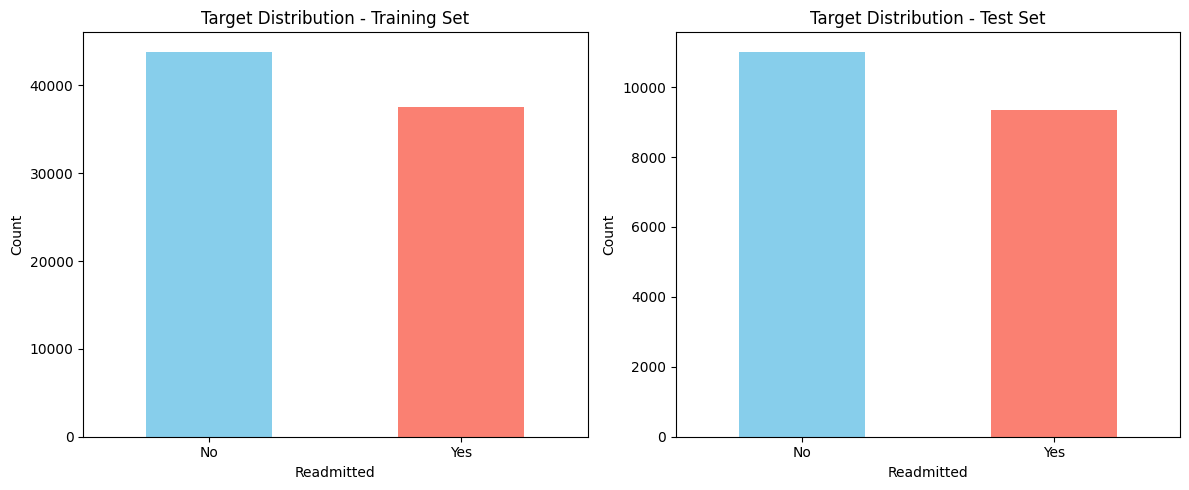

In [8]:
# Plot target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_df['readmitted'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution - Training Set')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.subplot(1, 2, 2)
test_df['readmitted'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution - Test Set')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()


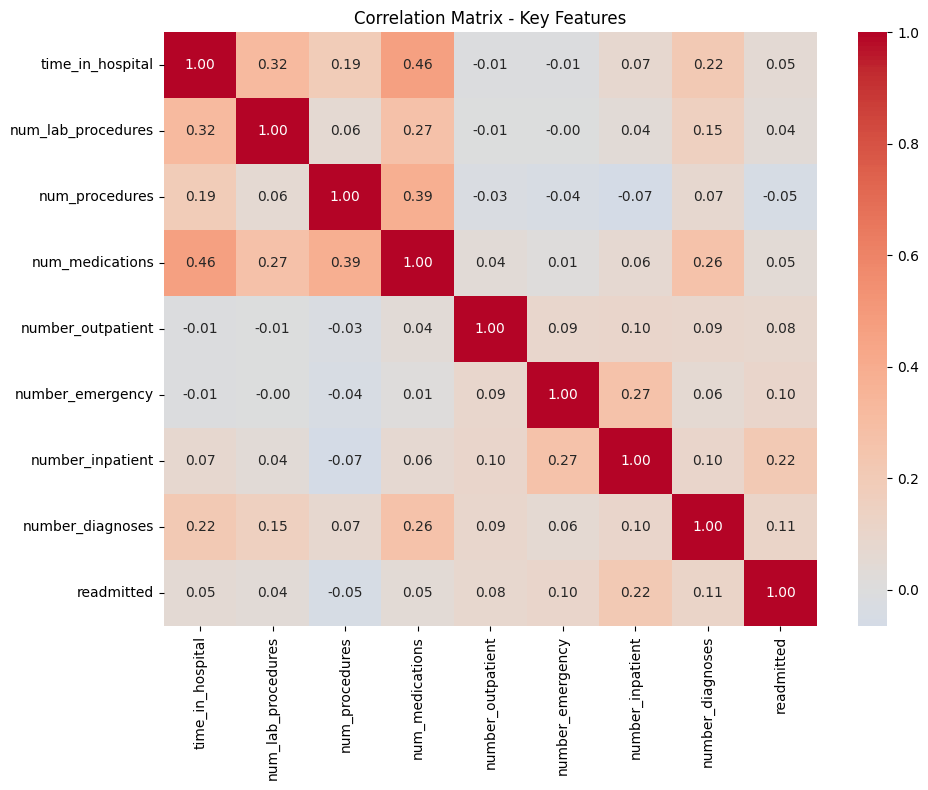

In [9]:
# Correlation heatmap for key numerical features
key_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                'num_medications', 'number_outpatient', 'number_emergency',
                'number_inpatient', 'number_diagnoses']

plt.figure(figsize=(10, 8))
correlation_matrix = train_df[key_features + ['readmitted']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix - Key Features')
plt.tight_layout()
plt.show()


In [ ]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# Define models to compare including XGBoost, CatBoost, and LightGBM

xgboost = xgb.XGBClassifier(
    tree_method="gpu_hist",          # or "gpu_hist" if you have CUDA ≥11.2
    max_depth=6,                 # shallow enough to generalise, fast to split
    learning_rate=0.05,
    n_estimators=5000,           # let early-stop truncate
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,              # L2 regularisation
    reg_alpha=0.0,               # enable if overfitting
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
)

lgbm = lgb.LGBMClassifier(
    boosting_type="gbdt",        # or "goss" for fewer rows / faster
    num_leaves=64,               # rule of thumb: 2^(max_depth)
    max_depth=-1,                # let num_leaves control complexity
    learning_rate=0.05,
    n_estimators=5000,
    subsample=0.8,
    subsample_freq=1,
    feature_fraction=0.8,
    lambda_l1=0.0,
    lambda_l2=1.0,
    random_state=42,
    n_jobs=-1,
    gpu_use_dp=False
)

catboost = cb.CatBoostClassifier(
    task_type="GPU",             # "GPU" if you have one; huge win
    depth=6,
    learning_rate=0.05,
    iterations=5000,
    l2_leaf_reg=3.0,
    random_state=42,
    loss_function="Logloss",
    od_type="Iter",              # ordered boosting + over-fit detector
    od_wait=100,
    verbose=False,
)

models = {
    'XGBoost': xgboost,
    'CatBoost': catboost,
    'LightGBM': lgbm
}

# Cross-validation scores
print("Cross-validation scores:")
cv_scores = {}
for name, model in models.items():
    if name != 'CatBoost':
      continue
    print("Training", name)
    scores = cross_val_score(model, X_train.values, y_train, cv=5, scoring='accuracy')

    cv_scores[name] = scores
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

In [12]:
# Train all models and evaluate on test set

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train.values, y_train)
    y_pred = model.predict(X_test.values)
    y_pred_proba = model.predict_proba(X_test.values)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")



Training XGBoost...
Accuracy: 0.6292
Precision: 0.6034
Recall: 0.5598
F1-Score: 0.5808
ROC AUC: 0.6725

Training CatBoost...
Accuracy: 0.6402
Precision: 0.6226
Recall: 0.5480
F1-Score: 0.5829
ROC AUC: 0.6914

Training LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Info] Number of positive: 37565, number of negative: 43845
[LightGBM] [Info] Auto-choosing row-

In [13]:
# Create results comparison DataFrame
results_df = pd.DataFrame({
    model: {metric: results[model][metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']}
    for model in results.keys()
}).T

print("Model Comparison:")
print(results_df.round(4))

Model Comparison:
          accuracy  precision  recall      f1  roc_auc
XGBoost     0.6292     0.6034  0.5598  0.5808   0.6725
CatBoost    0.6402     0.6226  0.5480  0.5829   0.6914
LightGBM    0.6263     0.5998  0.5574  0.5778   0.6711


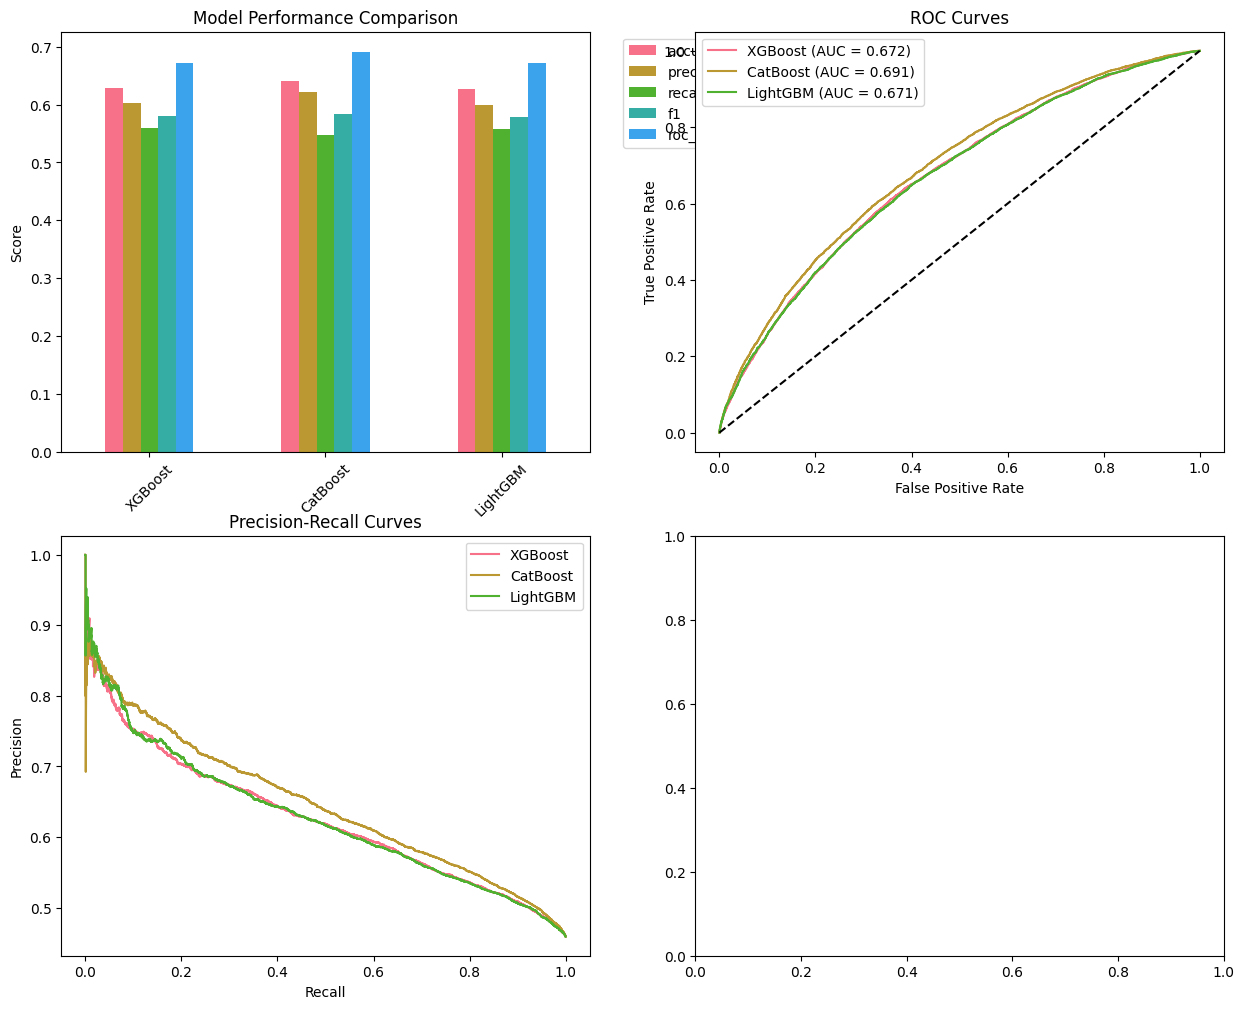

In [14]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance metrics comparison
results_df.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=45)

# ROC Curves
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
    axes[0, 1].plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})")

axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves')
axes[0, 1].legend()

# Precision-Recall Curves
for name in results.keys():
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, results[name]['probabilities'])
    axes[1, 0].plot(recall_vals, precision_vals, label=name)

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curves')
axes[1, 0].legend()

Best performing model: CatBoost
F1 Score: 0.5829


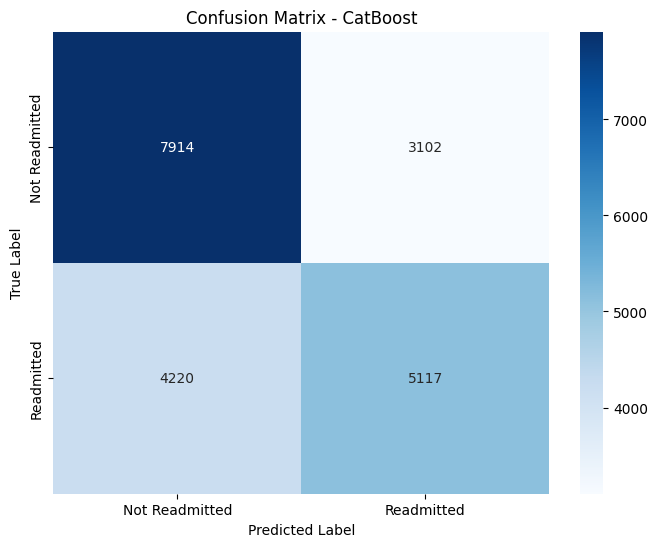


Classification Report - CatBoost:
                precision    recall  f1-score   support

Not Readmitted       0.65      0.72      0.68     11016
    Readmitted       0.62      0.55      0.58      9337

      accuracy                           0.64     20353
     macro avg       0.64      0.63      0.63     20353
  weighted avg       0.64      0.64      0.64     20353



In [15]:
# Find the best model based on F1 score
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_predictions = results[best_model_name]['predictions']

print(f"Best performing model: {best_model_name}")
print(f"F1 Score: {results[best_model_name]['f1']:.4f}")

# Confusion Matrix for best model
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, best_predictions,
                          target_names=['Not Readmitted', 'Readmitted']))


In [16]:
print("\n" + "="*50)
print("DIABETES READMISSION CLASSIFICATION RESULTS")
print("="*50)

print(f"\nDataset Information:")
print(f"- Training samples: {len(train_df)}")
print(f"- Test samples: {len(test_df)}")
print(f"- Number of features: {len(feature_columns)}")
print(f"- Target distribution (train): {dict(train_df['readmitted'].value_counts())}")

print(f"\nModel Performance Summary:")
for model_name in results.keys():
    print(f"\n{model_name}:")
    print(f"  - Accuracy:  {results[model_name]['accuracy']:.4f}")
    print(f"  - Precision: {results[model_name]['precision']:.4f}")
    print(f"  - Recall:    {results[model_name]['recall']:.4f}")
    print(f"  - F1-Score:  {results[model_name]['f1']:.4f}")
    print(f"  - ROC AUC:   {results[model_name]['roc_auc']:.4f}")

print(f"\nBest Model: {best_model_name} (F1-Score: {results[best_model_name]['f1']:.4f})")



DIABETES READMISSION CLASSIFICATION RESULTS

Dataset Information:
- Training samples: 81410
- Test samples: 20353
- Number of features: 150
- Target distribution (train): {0: np.int64(43845), 1: np.int64(37565)}

Model Performance Summary:

XGBoost:
  - Accuracy:  0.6292
  - Precision: 0.6034
  - Recall:    0.5598
  - F1-Score:  0.5808
  - ROC AUC:   0.6725

CatBoost:
  - Accuracy:  0.6402
  - Precision: 0.6226
  - Recall:    0.5480
  - F1-Score:  0.5829
  - ROC AUC:   0.6914

LightGBM:
  - Accuracy:  0.6263
  - Precision: 0.5998
  - Recall:    0.5574
  - F1-Score:  0.5778
  - ROC AUC:   0.6711

Best Model: CatBoost (F1-Score: 0.5829)
